**Final model: Baseline model +bbx + data_augmentation**

In [ ]:
# import the necessary packages
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import mimetypes
import argparse
import imutils
import cv2
import os

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive/')
os.chdir('/content/drive/My Drive/Data/')

Mounted at /content/drive/


*Step 1: Get the bounding box (bbx) regression*

In [ ]:
class Config:

    BASE_PATH = '/content/drive/My Drive/Data/Research/Process_2/'
    IMAGES_PATH = os.path.sep.join([BASE_PATH, "Train"])
    ANNOTS_PATH = os.path.sep.join([BASE_PATH, "hip_coord2.csv"])

    BASE_OUTPUT = '/content/drive/My Drive/Data/Research/Process_2/output/'


    TEST_FILENAMES = os.path.sep.join([BASE_OUTPUT, "test_images.txt"])


    INIT_LR = 1e-4
    NUM_EPOCHS = 10
    BATCH_SIZE = 32


config = Config()

In [ ]:

print("[INFO] loading dataset...")
rows = open(config.ANNOTS_PATH).read().strip().split("\n")

data = []
targets = []
filenames = []

[INFO] loading dataset...


In [ ]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [ ]:

for row in rows:
	row = row.split(",")
	(filename, startX, startY, endX, endY) = row


	imagePath = os.path.sep.join([config.IMAGES_PATH, filename])
	image = cv2.imread(imagePath)
	(h, w) = (128,128)


	startX = float(startX) / w
	startY = float(startY) / h
	endX = float(endX) / w
	endY = float(endY) / h

	image = load_img(imagePath, target_size=(128, 128))
	image = load_image_into_numpy_array(image)


	data.append(image)
	targets.append((startX, startY, endX, endY))
	filenames.append(filename)

In [ ]:

data = np.array(data, dtype="float32") / 255.0
targets = np.array(targets, dtype="float32")


split = train_test_split(data, targets, filenames, test_size=0.10,
	random_state=42)

(trainImages, testImages) = split[:2]
(trainTargets, testTargets) = split[2:4]
(trainFilenames, testFilenames) = split[4:]

print("[INFO] saving testing filenames...")
f = open(config.TEST_FILENAMES, "w")
f.write("\n".join(testFilenames))
f.close()

[INFO] saving testing filenames...


In [ ]:

vgg = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(128, 128, 3)))

vgg.trainable = False

flatten = vgg.output
flatten = Flatten()(flatten)


bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid")(bboxHead)


model = Model(inputs=vgg.input, outputs=bboxHead)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:

opt = Adam(lr=config.INIT_LR)
model.compile(loss="mse", optimizer=opt)
print(model.summary())


print("[INFO] training bounding box regressor...")
H = model.fit(
	trainImages, trainTargets,
	validation_data=(testImages, testTargets),
	batch_size=config.BATCH_SIZE,
	epochs=config.NUM_EPOCHS,
	verbose=1)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

[INFO] saving object detector model...


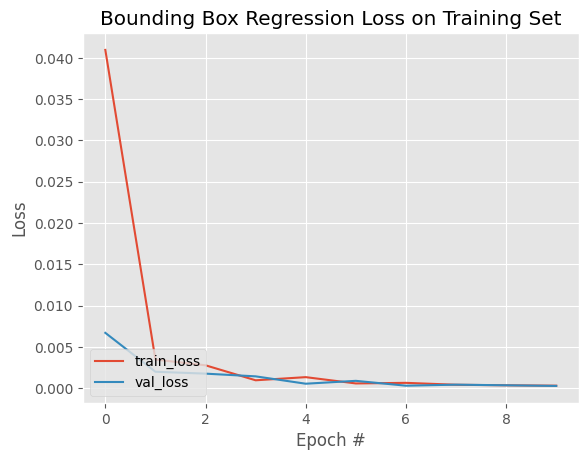

In [ ]:

print("[INFO] saving object detector model...")
model.save('detection', save_format="h5")

N = config.NUM_EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Bounding Box Regression Loss on Training Set")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.show()

In [ ]:
model.save('detection_mask.h5')

*Step 2: Apply predition for bbox on our 6400 image*

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt

import cv2
from tqdm import tqdm
import io
import seaborn as sns

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.applications import EfficientNetB4
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard,ModelCheckpoint

from sklearn.metrics import classification_report, confusion_matrix
from keras.utils.vis_utils import plot_model

import ipywidgets as widgets
from PIL import Image
from IPython.display import display, clear_output

In [ ]:
labels = ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']

In [ ]:
imagePaths = []
Y_train = [] #Training Labels

for i in labels:
    folderPath = os.path.join('/content/drive/My Drive/Data/Research/Process_1/', 'train', i)
    for j in tqdm(os.listdir(folderPath)):
      p = os.path.sep.join([folderPath, j])
      imagePaths.append(p)
      Y_train.append(i)

for i in labels:
    folderPath = os.path.join('/content/drive/My Drive/Data/Research/Process_1/', 'test', i)
    for j in tqdm(os.listdir(folderPath)):
      p = os.path.sep.join([folderPath, j])
      imagePaths.append(p)
      Y_train.append(i)

Ytrain = np.array(Y_train)

100%|██████████| 224/224 [00:00<00:00, 567003.08it/s]


In [ ]:
Ytrain.shape

(5761,)

In [ ]:

print("[INFO] loading object detector...")
model = load_model('detection_mask.h5')
X_train = [] #Training Dataset


for i in imagePaths:
  image = load_img(i, target_size=(128, 128,1))
  image = img_to_array(image) / 255.0
  image = np.expand_dims(image, axis=0)

  preds = model.predict(image)[0]
  (startX, startY, endX, endY) = preds
  image = cv2.imread(i)
  (h, w) = image.shape[:2]

  startX = int(startX * w)
  startY = int(startY * h)
  endX = int(endX * w)
  endY = int(endY * h)

  box_img = cv2.rectangle(image, (startX, startY), (endX, endY),(0, 255, 0), 2)
  X_train.append(box_img)



Xtrain = np.array(X_train)

Xtrain.shape

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 22ms/step


(5761, 128, 128, 3)

In [ ]:
Ytrain.shape

(5761,)

In [ ]:
Xtrain.shape

(5761, 128, 128, 3)

*Step 3: Befine base model*

In [ ]:
Xtrain, Ytrain = shuffle(Xtrain, Ytrain, random_state=42)

In [ ]:
xtrain,xtest, Ytrain,ytest = train_test_split(Xtrain, Ytrain,test_size=0.1, random_state=42)

In [ ]:
ytrain_new = []
ytest_new = []

for i in Ytrain:
    ytrain_new.append(labels.index(i))#Converting String Label to integer i.e

ytrain = to_categorical(ytrain_new) #Converts a class vector (integers) to binary class matrix

for i in ytest:
    ytest_new.append(labels.index(i))

ytest = to_categorical(ytest_new)

In [ ]:
image_size=128


In [ ]:
efficientnetB4= EfficientNetB4(include_top=False,weights='imagenet',input_shape=(image_size, image_size, 3))

71686520/71686520 [==============================] - 3s 0us/step


In [ ]:
# Output of model

model = efficientnetB4.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(0.5)(model)
model = tf.keras.layers.Dense(4, activation='softmax')(model)
model = tf.keras.models.Model(inputs=efficientnetB4.input, outputs=model)

In [ ]:
model.compile( optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [ ]:
filepath = './inception_bbox_v3.hdf5'

In [ ]:
tf.keras.callbacks.ModelCheckpoint(
filepath,
monitor = 'val_loss',
verbose = 0,
save_best_only  = False,
save_weights_only = False,
mode = 'auto',
save_freq='epoch',
options=None,
initial_value_threshold=None
 )

In [ ]:
tensorBoard = TensorBoard(log_dir="logs")
checkPoint = ModelCheckpoint("efficientNetB4.h5",
                            monitor='val_acc',
                            verbose=1,
                            save_best_only=True,
                            mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_acc',
                             factor=0.3,
                             patience=2,
                             verbose=1,
                             mode='auto',
                            min_delta=0.001)

*Step 4: Apply Data augmentation on the bbx images (Adding noise , random brightness)*

In [ ]:
import random
import numpy as np
def add_noise(img):
    '''Add random noise to an image'''
    VARIABILITY = 50
    deviation = VARIABILITY*random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(brightness_range=[0.2,1.0], preprocessing_function=add_noise)

In [ ]:
it_train = datagen.flow(xtrain, ytrain, batch_size=64)

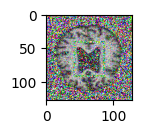

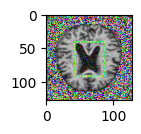

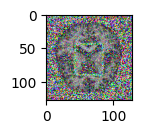

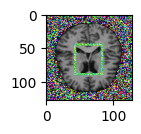

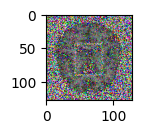

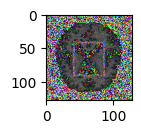

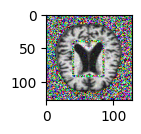

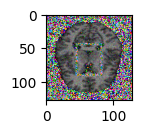

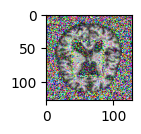

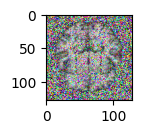

In [ ]:
from matplotlib import pyplot
# generate samples and plot
for i in range(10):
  pyplot.subplot(2, 5, 1 + i)
  batch = it_train.next()
  image = batch[0].astype('uint8')
  pyplot.imshow(image[i])
  pyplot.show()

*Step 5: Train & Evaluating the final best model*

In [ ]:
history = model.fit(it_train,
                    epochs=20,
                    validation_data=(xtest,ytest),
                    verbose=1,
                    callbacks=[tensorBoard, checkPoint, reduce_lr])

Epoch 1/20
81/81 [==============================] - ETA: 0s - loss: 1.0573 - accuracy: 0.4938

81/81 [==============================] - 130s 500ms/step - loss: 1.0573 - accuracy: 0.4938 - val_loss: 1.1835 - val_accuracy: 0.5061 - lr: 0.0010
Epoch 2/20
81/81 [==============================] - ETA: 0s - loss: 0.8736 - accuracy: 0.5847

81/81 [==============================] - 36s 438ms/step - loss: 0.8736 - accuracy: 0.5847 - val_loss: 0.8347 - val_accuracy: 0.6343 - lr: 0.0010
Epoch 3/20
81/81 [==============================] - ETA: 0s - loss: 0.7378 - accuracy: 0.6684

81/81 [==============================] - 36s 436ms/step - loss: 0.7378 - accuracy: 0.6684 - val_loss: 0.8242 - val_accuracy: 0.6846 - lr: 0.0010
Epoch 4/20
81/81 [==============================] - ETA: 0s - loss: 0.5674 - accuracy: 0.7627

81/81 [==============================] - 36s 439ms/step - loss: 0.5674 - accuracy: 0.7627 - val_loss: 0.5949 - val_accuracy: 0.8111 - lr: 0.0010
Epoch 5/20
81/81 [==============================] - ETA: 0s - loss: 0.4216 - accuracy: 0.8285

81/81 [==============================] - 36s 437ms/step - loss: 0.4216 - accuracy: 0.8285 - val_loss: 0.8939 - val_accuracy: 0.7522 - lr: 0.0010
Epoch 6/20
81/81 [==============================] - ETA: 0s - loss: 0.2829 - accuracy: 0.8870

81/81 [==============================] - 36s 437ms/step - loss: 0.2829 - accuracy: 0.8870 - val_loss: 0.6013 - val_accuracy: 0.8614 - lr: 0.0010
Epoch 7/20
81/81 [==============================] - ETA: 0s - loss: 0.2526 - accuracy: 0.9078

81/81 [==============================] - 36s 438ms/step - loss: 0.2526 - accuracy: 0.9078 - val_loss: 0.1772 - val_accuracy: 0.9324 - lr: 0.0010
Epoch 8/20
81/81 [==============================] - ETA: 0s - loss: 0.1799 - accuracy: 0.9329

81/81 [==============================] - 36s 438ms/step - loss: 0.1799 - accuracy: 0.9329 - val_loss: 0.2157 - val_accuracy: 0.9393 - lr: 0.0010
Epoch 9/20
81/81 [==============================] - ETA: 0s - loss: 0.1703 - accuracy: 0.9367

81/81 [==============================] - 36s 437ms/step - loss: 0.1703 - accuracy: 0.9367 - val_loss: 0.1182 - val_accuracy: 0.9636 - lr: 0.0010
Epoch 10/20
81/81 [==============================] - ETA: 0s - loss: 0.1381 - accuracy: 0.9489

81/81 [==============================] - 35s 436ms/step - loss: 0.1381 - accuracy: 0.9489 - val_loss: 0.2630 - val_accuracy: 0.9081 - lr: 0.0010
Epoch 11/20
81/81 [==============================] - ETA: 0s - loss: 0.1229 - accuracy: 0.9545

81/81 [==============================] - 36s 438ms/step - loss: 0.1229 - accuracy: 0.9545 - val_loss: 0.1242 - val_accuracy: 0.9584 - lr: 0.0010
Epoch 12/20
81/81 [==============================] - ETA: 0s - loss: 0.1166 - accuracy: 0.9587

81/81 [==============================] - 36s 437ms/step - loss: 0.1166 - accuracy: 0.9587 - val_loss: 0.0700 - val_accuracy: 0.9775 - lr: 0.0010
Epoch 13/20
81/81 [==============================] - ETA: 0s - loss: 0.1119 - accuracy: 0.9585

81/81 [==============================] - 36s 438ms/step - loss: 0.1119 - accuracy: 0.9585 - val_loss: 0.1505 - val_accuracy: 0.9497 - lr: 0.0010
Epoch 14/20
81/81 [==============================] - ETA: 0s - loss: 0.0899 - accuracy: 0.9660

81/81 [==============================] - 36s 438ms/step - loss: 0.0899 - accuracy: 0.9660 - val_loss: 0.0622 - val_accuracy: 0.9757 - lr: 0.0010
Epoch 15/20
81/81 [==============================] - ETA: 0s - loss: 0.0811 - accuracy: 0.9693

81/81 [==============================] - 36s 437ms/step - loss: 0.0811 - accuracy: 0.9693 - val_loss: 0.1124 - val_accuracy: 0.9653 - lr: 0.0010
Epoch 16/20
81/81 [==============================] - ETA: 0s - loss: 0.0681 - accuracy: 0.9759

81/81 [==============================] - 36s 436ms/step - loss: 0.0681 - accuracy: 0.9759 - val_loss: 0.0591 - val_accuracy: 0.9792 - lr: 0.0010
Epoch 17/20
81/81 [==============================] - ETA: 0s - loss: 0.0736 - accuracy: 0.9749

81/81 [==============================] - 36s 438ms/step - loss: 0.0736 - accuracy: 0.9749 - val_loss: 0.2438 - val_accuracy: 0.9289 - lr: 0.0010
Epoch 18/20
81/81 [==============================] - ETA: 0s - loss: 0.0741 - accuracy: 0.9730

81/81 [==============================] - 36s 436ms/step - loss: 0.0741 - accuracy: 0.9730 - val_loss: 0.0895 - val_accuracy: 0.9723 - lr: 0.0010
Epoch 19/20
81/81 [==============================] - ETA: 0s - loss: 0.0793 - accuracy: 0.9715

81/81 [==============================] - 36s 437ms/step - loss: 0.0793 - accuracy: 0.9715 - val_loss: 0.1609 - val_accuracy: 0.9653 - lr: 0.0010
Epoch 20/20
81/81 [==============================] - ETA: 0s - loss: 0.0755 - accuracy: 0.9730

81/81 [==============================] - 36s 437ms/step - loss: 0.0755 - accuracy: 0.9730 - val_loss: 0.0232 - val_accuracy: 0.9931 - lr: 0.0010


In [ ]:
pred = model.predict(xtest)
pred = np.argmax(pred, axis=1)
actual_label = np.argmax(ytest, axis=1)
print(classification_report(actual_label, pred))

19/19 [==============================] - 4s 52ms/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.98        81
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00       291
           3       0.99      0.99      0.99       197

    accuracy                           0.99       577
   macro avg       0.99      0.99      0.99       577
weighted avg       0.99      0.99      0.99       577



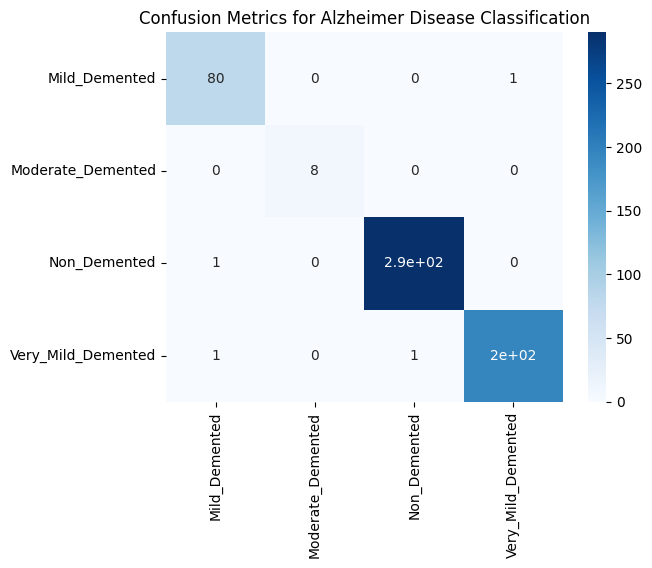

In [ ]:
Cm=confusion_matrix(actual_label,pred)
ax=plt.axes()
sns.heatmap(Cm, cmap='Blues' ,annot=True,
           annot_kws={'size':10},
           xticklabels=labels,
           yticklabels=labels,
           ax=ax
           )

plt.title("Confusion Metrics for Alzheimer Disease Classification")
plt.show()

In [ ]:
def accuracy_and_loss_Plot(modelData):

    fig=plt.figure(figsize=(10,10))

    plt.subplot(221)
    plt.plot(modelData.history["accuracy"], 'bo--',label='accuracy')
    plt.plot(modelData.history["val_accuracy"],'ro--',label='val_accuracy')
    plt.title("Training Data Accuracy Measurements")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Accuracy Information")
    plt.legend()
    plt.tight_layout()

    plt.subplot(222)
    plt.plot(modelData.history["loss"], 'bo--',label='loss')
    plt.plot(modelData.history["val_loss"],'ro--',label='val_loss')
    plt.title("Training Data Loss Measurements")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Loss Information")
    plt.legend()
    plt.tight_layout()

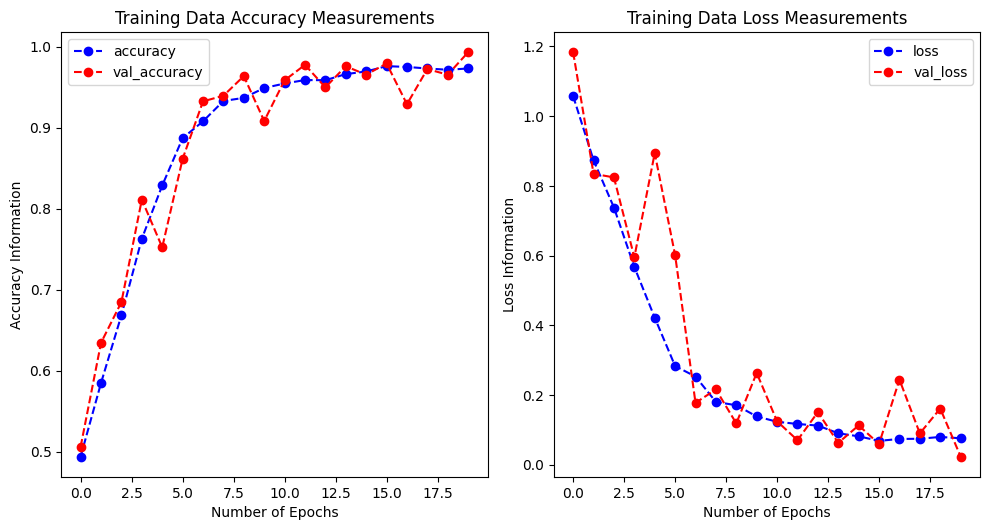

In [ ]:
accuracy_and_loss_Plot(history)

In [ ]:
final_research_model = model
tf.saved_model.save(final_research_model, '/content/drive/My Drive/Data/Research/Process_1/output/')